In [50]:
%matplotlib inline
import math
import os
import mne
import pandas as pd
from mne.externals.pymatreader import read_mat 
import numpy as np
import matplotlib.pyplot as plt
import itertools
from glob import glob
from scipy import io

# import pyriemann

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import mutual_info_score

In [2]:
data_path='/Users/charlesgirard/Desktop/Centrale/ei2/Projet/P01'
n_subs = 4
n_sessions = 2
diff = ['MATBeasy', 'MATBmed', 'MATBdiff']

In [3]:
electrodes = pd.read_csv(data_path + '/S1/electrode_positions/get_chanlocs.txt',header=None, names=['ch_names','x','y','z'],delim_whitespace=True)
electrodes.head()
#reagrder noms channels

,ch_names,x,y,z
0,Fp1,105.9276,29.3422,66.8159
1,Fz,66.4484,-2.1494,123.7135
2,F3,59.9094,45.3245,102.7517
3,F7,62.0175,68.6308,59.5730
4,F9,34.2379,78.5712,7.9506


array([1, 2])

(500,)



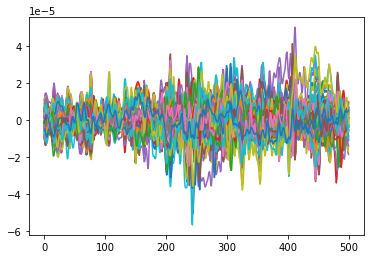

In [4]:
eeg=mne.io.read_epochs_eeglab(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set', verbose=False)
# eeg = io.loadmat(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set',appendmat=False)
tmp = eeg.get_data()
# print(tmp.shape)
testVect=np.zeros((1,149*500))
print(tmp[1,0].shape)
print()

    
for i in range (61):
    plt.plot(tmp[0,i])

(61, 500)


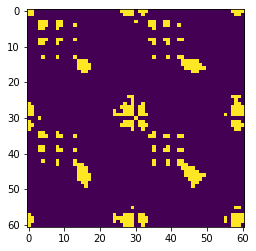

In [5]:
eeg=mne.io.read_epochs_eeglab(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set', verbose=False)
# eeg = io.loadmat(data_path+'/S1/eeg/alldata_sbj01_sess1_MATBdiff.set',appendmat=False)
tmp = eeg.get_data()

# for i in range (61):
#     plt.plot(tmp[0,i])

def reshape(signal):
    (a,b,c)=signal.shape
    output=np.zeros((b,a*c))
    for i in range (a):
        for j in range (b):
            output[j,i*500:(i+1)*500]=signal[i,j,:]
    return (output)

            

tmp2 = tmp.view()
tmp2=np.reshape(tmp2,(61,149*500),order='C')

# signalTotal=tmp2

signalTotal=reshape(tmp)


# plt.subplot(2,2,1)
# plt.plot(tmp[0,0,:])
# plt.subplot(2,2,2)
# plt.plot(tmp[1,0,:])

# plt.subplot(2,2,3)
# plt.plot(signalTotal[0,0:500])
# plt.subplot(2,2,4)
# plt.plot(signalTotal[0,500:1000])

def correlation_threshold(signal,fenetre, indice,k=10**(-10)):
    corr= np.corrcoef(signal[:,indice:indice+fenetre])
#     print(signal[:,indice:indice+fenetre].shape)
    (a,b)=corr.shape
    threshold=np.zeros((a,b))

    for i in range (a):
        for j in range (b):
            if corr[i,j]>k:
                threshold[i,j]=1
    return threshold

def covariance_threshold(signal,fenetre, indice,k=10**(-10)):
    cov= np.cov(signal[:,indice:indice+fenetre])
    print(signal[:,indice:indice+fenetre].shape)
    (a,b)=cov.shape
    threshold=np.zeros((a,b))

    for i in range (a):
        for j in range (b):
            if cov[i,j]>k:
                threshold[i,j]=1
    return threshold

plt.imshow(covariance_threshold(signalTotal,500,1000))


##pour une epoch de 2 secondes
cov=np.cov(tmp[2,:])


# print(cov)

##pour les 5 mins


cov2=np.cov(tmp2)
corr2= np.corrcoef(tmp2)

# plt.plot(tmp2)
# print(tmp2.shape)
# plt.imshow(corr2)


# plt.imshow(cov)

k=10**(-10)
(a,b)=cov.shape
threshold=np.zeros((a,b))

for i in range (a):
    for j in range (b):
        if cov[i,j]>k:
            threshold[i,j]=1
        


In [19]:
k=10**(-9)
k

1e-09

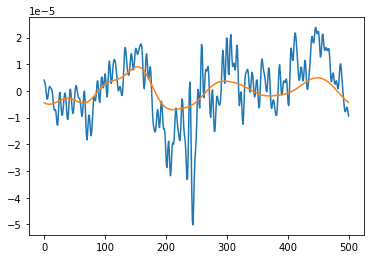

In [14]:
##filtrage fréquentiel

signalTest=tmp[0,0]

def signal_freq_filtre(signal,freqs,fenetre):
    tf=np.fft.fft(signal)
#     print(tf)

    n = signal.size
    timestep = 1/250
    freq = np.fft.fftfreq(n, d=timestep)

    if freqs=='delta':
        waves=[0.5, 4.5]
    elif freqs=='beta':
        waves=[12 ,35.5]
    elif freqs=='theta':
        waves=[4, 8.5]
    elif freqs=='alpha':
        waves=[8, 12.5]
    elif freqs=='gamma':
        waves=[35, 1000]
    output=np.zeros(len(tf))
    
#     for i in range (len(tf)):
#         if i/2 < waves[1] and i/2>waves[0]:
#             output[i]=tf[i]

    for i in range (len(tf)):
        if i/2 > waves[1] or i/2<=waves[0]:
            tf[i]=0
    output=tf
    return(np.real(np.fft.ifft(output)))
    
plt.plot(signalTest)
# plt.plot(signal_freq_filtre(signalTest,'gamma',1)+signal_freq_filtre(signalTest,'beta',1)+signal_freq_filtre(signalTest,'alpha',1)+signal_freq_filtre(signalTest,'delta',1)+signal_freq_filtre(signalTest,'theta',1))
plt.plot(signal_freq_filtre(signalTest,'delta',1))

In [7]:

## fonction qui renvoi les 61 signaux de indice à indice+fenetre

def signalCourt(signal,ind, size):
    return signal[:,ind:ind+size]

# plt.plot(signalCourt(signalTotal,0,100)[0])
# plt.plot(signalCourt(signalTotal,10,200)[0])



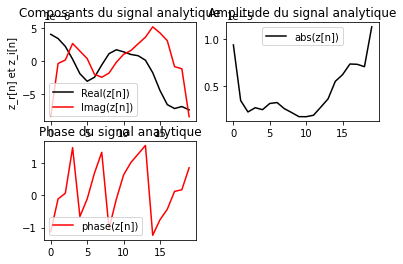

In [8]:
def analytic_signal(x):
    from scipy.fftpack import fft,ifft
    N = len(x)
    X = fft(x,N)
    h = np.zeros(N)
    h[0] = 1
    h[1:N//2] = 2*np.ones(N//2-1)
    h[N//2] = 1
    Z = X*h
    z = ifft(Z,N)
    return z

def phase_analytique(x): #signal analytique en input
    phi=np.arctan(x.imag/x.real)
    return phi

def amplitude_analytique(x): #signal analytique en input
    return abs(x)

z = analytic_signal(signalCourt(signalTotal,0,20)[0])
# t = np.arange(start=0,stop=0.5,step=0.001)
    

plt.subplot(2,2,1)
plt.plot(z.real,'k',label='Real(z[n])') #sans axe des temps
plt.plot(z.imag,'r',label='Imag(z[n])') #sans axe des temps
plt.title('Composants du signal analytique')
plt.xlabel('n')
plt.ylabel('z_r[n] et z_i[n]')
plt.legend()

plt.subplot(2,2,2)
plt.plot(amplitude_analytique(z),'k',label='abs(z[n])') #sans axe des temps
# plt.plot(phase,'r',label='phase(z[n])') #sans axe des temps
plt.title('Amplitude du signal analytique')
plt.legend()

plt.subplot(2,2,3)
plt.plot(phase_analytique(z),'r',label='phase(z[n])') #sans axe des temps
plt.title('Phase du signal analytique')
plt.legend()



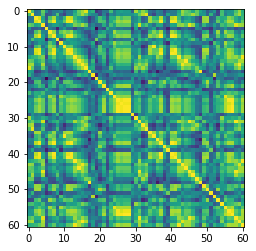

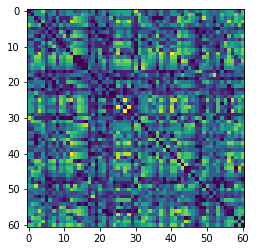

In [33]:
##phase locking value pour un pour une bande de fréquence quelconque

A=np.zeros((61,61))
for i in range (61):
    for j in range (61):
        ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,0,20)[i],'delta',20)))
        ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,0,20)[j],'delta',20)))
        dph=ph1-ph2

        PLV=abs(np.sum(np.exp(1j*(dph))))/len(ph1)
        A[i,j]=PLV

plt.figure(1)
plt.imshow(A)
# plt.plot(dph)


##Phase lag index

B=np.zeros((61,61))
for i in range (61):
    for j in range (61):
        ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,0,20)[i],'delta',20)))
        ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,0,20)[j],'delta',20)))
        
        dph=ph1-ph2

        PLI=abs(np.sum(np.sign(np.imag(np.exp(1j*(dph))))))/len(ph1)
        B[i,j]=PLI

        
plt.figure(2)
plt.imshow(B)


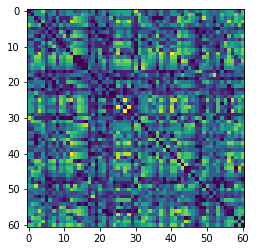

In [41]:
def matPLV(signal, fenetre, indice, freq):
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,indice,fenetre)[i],freq,fenetre)))
            ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signalTotal,indice,fenetre)[j],freq,fenetre)))
            dph=ph1-ph2

            PLV=abs(np.sum(np.exp(1j*(dph))))/len(ph1)
            A[i,j]=PLV
    return (A)

def matPLI(signal, fenetre, indice, freq):
    B=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            ph1=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[i],freq,fenetre)))
            ph2=phase_analytique(analytic_signal(signal_freq_filtre(signalCourt(signal,indice,fenetre)[j],freq,fenetre)))
        
            dph=ph1-ph2

            PLI=abs(np.sum(np.sign(np.imag(np.exp(1j*(dph))))))/len(ph1)
            B[i,j]=PLI
    return (B)

plt.imshow(matPLI(signalTotal, 20, 0, 'delta'))

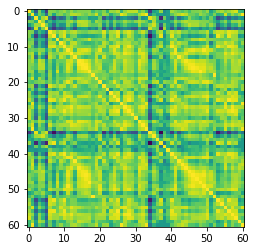

In [48]:
##calcul correlation d'enveloppe


# enveloppe = amplitude_analytique(analytic_signal(signalCourt(signalTotal,0,50)[0]))
# plt.plot(enveloppe)
# plt.plot(signalCourt(signalTotal,0,50)[0])

def matCorrEnv(signal, fenetre, indice, freq):
    A=np.zeros((61,61))
    corr= np.corrcoef(amplitude_analytique(analytic_signal(signalCourt(signal,indice,fenetre))))
    return (corr)

plt.imshow(matCorrEnv(signalTotal,30,0,'alpha'))

In [54]:
def matInfoMut(signal, indice, fenetre):
    A=np.zeros((61,61))
    for i in range (61):
        for j in range (61):
            A[i,j]=mutual_info_score(signalCourt(signalTotal,indice,fenetre)[i],signalCourt(signalTotal,indice,fenetre)[j])
            
    return (A)

print(matInfoMut(signalTotal, 0, 20))

[[2.99573227 2.99573227 2.99573227 ... 2.99573227 2.99573227 2.99573227]
 [2.99573227 2.99573227 2.99573227 ... 2.99573227 2.99573227 2.99573227]
 [2.99573227 2.99573227 2.99573227 ... 2.99573227 2.99573227 2.99573227]
 ...
 [2.99573227 2.99573227 2.99573227 ... 2.99573227 2.99573227 2.99573227]
 [2.99573227 2.99573227 2.99573227 ... 2.99573227 2.99573227 2.99573227]
 [2.99573227 2.99573227 2.99573227 ... 2.99573227 2.99573227 2.99573227]]
